# Load Modules

In [7]:
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
%matplotlib inline

In [8]:
mpl.font_manager._rebuild()
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'

In [3]:
def load_data_suffixes(file_pairs, src_dir='', dst_dir='.', suffixes=None):
    import os
    if not os.path.isdir(dst_dir):
        os.mkdir(dst_dir)
    if not suffixes:
        for file_pair in file_pairs:
            src = os.path.abspath(os.path.expanduser(os.path.join(src_dir, file_pair[0])))
            dst = os.path.expanduser(os.path.join(dst_dir, file_pair[1]))
            if os.path.isfile(dst):
                os.remove(dst)
            if not os.path.islink(dst):
                os.symlink(src, dst)
    else:
        for file_pair in file_pairs:
            for suffix_pair in suffixes:
                src = os.path.abspath(os.path.expanduser(
                    os.path.join(src_dir, file_pair[0] + suffix_pair[0])))
                dst = os.path.expanduser(
                    os.path.join(dst_dir, file_pair[1] + suffix_pair[1]))
                if os.path.isfile(dst):
                    os.remove(dst)
                if not os.path.islink(dst):
                    os.symlink(src, dst)


# Replicates correlation

## bar plot -- Fig.S1D

In [3]:
import os
os.chdir('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/replicates/rep_corr')

In [8]:
# load promoter
import subprocess
cmd = '''grep NM ~wangwen/source/bySpecies/hg38/hg38.refGene.genePredExt | awk '{if($3=="+") print $2"\t"$4-3000"\t"$4+3000"\t"$1"\t0\t"$3; else print $2"\t"$5-3000"\t"$5+3000"\t"$1"\t0\t"$3}' | awk '{if($2<0) print $1"\t0\t"$3"\t"$4"\t"$5"\t"$6; else print $0}' > hg38_refGene_promoter.bed'''
subprocess.call(cmd,shell=True)

0

In [9]:
bw_scan = True
import os


def flatten(items):
    for x in items:
        yield from x


promoter_file = 'hg38_refGene_promoter.bed'
for index, (factor, stages) in enumerate({'ATF1':['1e5','1e4','5e3', 'FlagCR_1e5', 'FlagCR_5e3', 'wtCR_1e5'],'ELF1':['1e5','1e4','5e3', 'FlagCR_1e5', 'FlagCR_5e3', 'wtCR_1e5']}.items()):
    bw_scan_cmd = f'~/bin/utilities/getBigWigValue.py -p 20 -n {factor}_promoter -p 8 -s 1 -m speed -b {promoter_file}'
    samples = [[f'{stage}_rep1',f'{stage}_rep2',f'{stage}_rep3'] for stage in stages]
    samples = flatten(samples)
    #print(list(samples))
    for sample in samples:
        if os.path.isfile(f'../{factor}_{sample}.bw'):
            bw_scan_cmd += f' -w ../{factor}_{sample}.bw'
    if bw_scan:
        subprocess.check_output(bw_scan_cmd, shell=True).decode()

In [15]:
import os
import gzip
from scipy.stats.mstats import pearsonr

def iter_data(scaned_result_file):
    with gzip.open(scaned_result_file, 'rt') as fhd:
        for line in fhd:
            yield line.strip()


def gen_corr():
    for index, (factor, stages) in enumerate({'ATF1':['1e5','1e4','5e3', 'FlagCR_1e5', 'FlagCR_5e3', 'wtCR_1e5'],'ELF1':['1e5','1e4','5e3', 'FlagCR_1e5', 'FlagCR_5e3', 'wtCR_1e5']}.items()):
    
        for j, stage in enumerate(stages):
            signal = []
            for i in range(j*3,j*3+3):
                if os.path.isfile(f'signal_{factor}_promoter_siteprof{i+1}.gz'):
                    signal.append(iter_data(f'signal_{factor}_promoter_siteprof{i+1}.gz'))
            promoter_signal = pd.DataFrame(signal, dtype=float).T
            yield pearsonr(promoter_signal.iloc[:,0],promoter_signal.iloc[:,1])[0], f'{factor}_{stage}'
            if promoter_signal.shape[1] > 2:
                yield pearsonr(promoter_signal.iloc[:,1],promoter_signal.iloc[:,2])[0], f'{factor}_{stage}'
                yield pearsonr(promoter_signal.iloc[:,0],promoter_signal.iloc[:,2])[0], f'{factor}_{stage}'

replicates_correlation = pd.DataFrame(gen_corr(),columns=['correlation','sample'])
replicates_correlation.head()

,correlation,sample
0,0.916845,ATF1_1e5
1,0.967900,ATF1_1e5
2,0.929148,ATF1_1e5
3,0.931367,ATF1_1e4
4,0.908713,ATF1_1e4


                 correlation
sample                      
ATF1_1e4            0.912669
ATF1_1e5            0.937964
ATF1_5e3            0.875820
ATF1_FlagCR_1e5     0.970912
ATF1_FlagCR_5e3     0.784655
ATF1_wtCR_1e5       0.958568


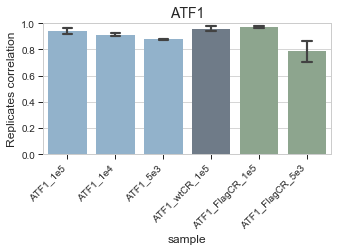

In [40]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75), tight_layout=True)
    loc_ls = list(range(9)) + list(range(15,18)) + list(range(9,15))
    print(replicates_correlation.iloc[loc_ls, :].groupby('sample').mean())
    sns.barplot(x='sample',
                y='correlation',
                data=replicates_correlation.iloc[loc_ls, :],
                palette=['#92B2CB','#92B2CB','#92B2CB','#6F7B88','#8DA58E', '#8DA58E'],
                ci='sd',
                saturation=1,
                capsize=.2,
                edgecolor='none',
                ax=ax)
    ax.set_ylabel('Replicates correlation')
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
    ax.set_title('ATF1')
    ax.set_ylim(0, 1)
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig1D_1_replicate_correlation_ATF1.pdf',
                transparent=True)
    

                 correlation
sample                      
ELF1_1e4            0.882417
ELF1_1e5            0.915287
ELF1_5e3            0.884995
ELF1_FlagCR_1e5     0.850585
ELF1_FlagCR_5e3     0.776895
ELF1_wtCR_1e5       0.896174


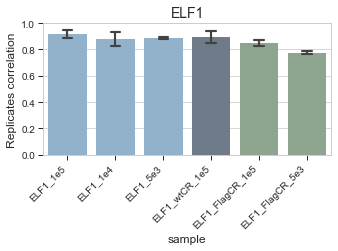

In [41]:
with sns.axes_style('whitegrid', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    fig, ax = plt.subplots(figsize=(6.4 * .75, 4.8 * .75), tight_layout = True)
    loc_ls = list(range(9)) + list(range(15,18)) + list(range(9,15))
    loc_ls_1 = [x+18 for x in loc_ls]
    print(replicates_correlation.iloc[loc_ls_1, :].groupby('sample').mean())
    sns.barplot(x='sample',
                y='correlation',
                data=replicates_correlation.iloc[loc_ls_1, :],
                palette=['#92B2CB','#92B2CB','#92B2CB','#6F7B88','#8DA58E', '#8DA58E'],
                ci='sd',
                saturation=1,
                capsize=.2,
                edgecolor='none',
                ax=ax)
    ax.set_ylabel('Replicates correlation')
    ax.set_xticklabels(ax.get_xticklabels(), ha='right', rotation=45)
    ax.set_title('ELF1')
    ax.set_ylim(0, 1)
    fig.savefig('/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig1D_2_replicate_correlation_ELF1.pdf',
                transparent=True)
    

## heatmap -- Fig.S1E

In [4]:
%%bash
pwd

/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/TF/replicates/rep_corr


In [5]:
bw_scan = False
import os


def flatten(items):
    for x in items:
        yield from x


promoter_file = 'hg38_refGene_promoter.bed'
for index, (factor, stages) in enumerate({'IgG':['public_GSE120011']}.items()):
    bw_scan_cmd = f'~/bin/utilities/getBigWigValue.py -p 20 -n {factor}_promoter -p 8 -s 1 -m speed -b {promoter_file}'
    samples = [[f'{stage}'] for stage in stages]
    samples = flatten(samples)
    #print(list(samples))
    for sample in samples:
        if os.path.isfile(f'../{factor}_{sample}.bw'):
            bw_scan_cmd += f' -w ../{factor}_{sample}.bw'
    if bw_scan:
        subprocess.check_output(bw_scan_cmd, shell=True).decode()

In [9]:
heatmap_signal = pd.DataFrame()
i = 0
for input_material in ['1e5', '1e4', '5e3']:
    for rep in range(1, 4):
        i += 1
        heatmap_signal[f'ATF1_{input_material}_rep{rep}'] = pd.read_csv(
            f'signal_ATF1_promoter_siteprof{i}.gz', sep='\t', header=None)[0]
i = 0
for input_material in ['1e5', '1e4', '5e3']:
    for rep in range(1, 4):
        i += 1
        heatmap_signal[f'ELF1_{input_material}_rep{rep}'] = pd.read_csv(
            f'signal_ELF1_promoter_siteprof{i}.gz', sep='\t', header=None)[0]
i = 0
for input_material in ['IgG']:
    for rep in range(1,2):
        i += 1
        if os.path.isfile(f'signal_IgG_promoter_siteprof{i}.gz'):
            heatmap_signal[f'IgG_{input_material}_rep{rep}'] = pd.read_csv(
                f'signal_IgG_promoter_siteprof{i}.gz', sep='\t',
                header=None)[0]
heatmap_signal.head()

,ATF1_1e5_rep1,ATF1_1e5_rep2,ATF1_1e5_rep3,ATF1_1e4_rep1,ATF1_1e4_rep2,ATF1_1e4_rep3,ATF1_5e3_rep1,ATF1_5e3_rep2,ATF1_5e3_rep3,ELF1_1e5_rep1,ELF1_1e5_rep2,ELF1_1e5_rep3,ELF1_1e4_rep1,ELF1_1e4_rep2,ELF1_1e4_rep3,ELF1_5e3_rep1,ELF1_5e3_rep2,ELF1_5e3_rep3,IgG_IgG_rep1
0,0.042294,0.154789,0.075041,0.074702,0.038085,0.039390,0.028138,0.019913,0.028054,0.027204,0.030743,0.033290,0.026904,0.022079,0.020372,0.026411,0.015336,0.031700,0.018183
1,0.044983,0.082133,0.067375,0.021343,0.042954,0.043580,0.035172,0.028210,0.035487,0.085481,0.097089,0.064126,0.034590,0.059985,0.038480,0.028172,0.022393,0.040084,0.027275
2,0.051339,0.123200,0.059030,0.050690,0.064534,0.021485,0.033413,0.019913,0.026080,0.072125,0.260376,0.127135,0.090319,0.100219,0.036216,0.047540,0.035955,0.054827,0.009092
3,0.021147,0.015795,0.015874,0.013340,0.009585,0.017524,0.024620,0.021572,0.033640,0.018699,0.039470,0.019147,0.023060,0.034154,0.028954,0.024650,0.037847,0.028789,0.009092
4,0.035632,0.121094,0.062269,0.061536,0.064380,0.030437,0.029896,0.041486,0.020453,0.093495,0.399663,0.180498,0.151813,0.136271,0.061115,0.045779,0.053853,0.073872,0.027275


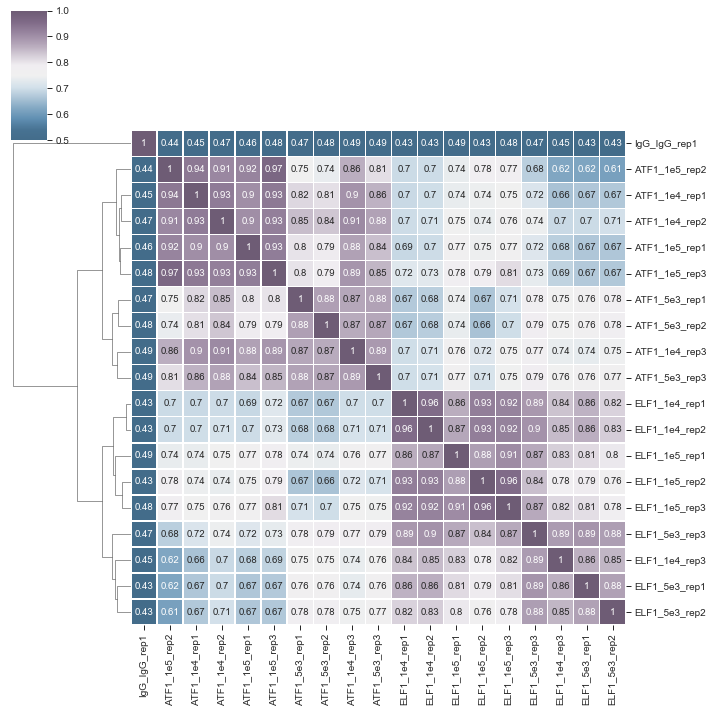

In [53]:
corr = heatmap_signal.corr()
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 10
                         }):
    

#     colors = ['#77325A', '#C371A0', '#D7A0BF', '#E5C2D6', '#EFDAE6', '#FBF7F9', '#F0F0F0', '#E9F0F6', '#CCDDE9', '#B3CCDF', '#95B8D2', '#71A0C3', '#325976'][::-1]
#     colors = ['#683276', '#8D549B', '#AC7CB8', '#C9A9D1', '#E3D4E7', '#F5EFF6', '#F0F0F0', '#D5E2EB', '#ADC5D7', '#83A8C3', '#608FB2', '#477292', '#375871'][::-1]
    colors = ['#6E5C75', '#7F6A87', '#98859F', '#B2A3B7', '#D2CAD5', '#F0EDF1', '#F0F0F0', '#D5E2EB', '#ADC5D7', '#83A8C3', '#608FB2', '#477292', '#436C8A'][::-1]
    cmap1 = mpl.colors.LinearSegmentedColormap.from_list("mycmap", colors)
    
    cmap2 = sns.color_palette("ch:start=.2,rot=-.3")
    cmap3 = 'Blues'
    cmap4 = sns.diverging_palette(220, 20)
    cmap5 = 'vlag'
    cmap6 = 'crest'
    cmap7 = sns.cubehelix_palette(start=.5, rot=-.75)
    cmap8 = "mako"
    cmap9 = 'YlGnBu'

    # Draw the heatmap with the mask and correct aspect ratio\
    g = sns.clustermap(corr,
                #mask=mask,
#                 cmap='RdBu_r',
                cmap=cmap1,      
                vmin=.5,
                vmax=1,
                square=True,
                linewidths=.5,
                cbar_kws={"shrink": .5},
                annot=True,
                )
    g.ax_col_dendrogram.set_visible(False)
    g.savefig(f'/mnt/Storage/home/wangyiman/fitCUTRUN/revision_1/analysis/figures/Supple_Fig1E_repCorr_promoter_signal.pdf',transparent=True)